## Introduction

The booming online gaming industry is a mutually beneficial ecosystem for entrepreneurs, players and gaming developers, providing them opportunities to satiate their lucrative appetite for online gaming. In a recent report by ResearchAndMarkets, the global gaming market was valued at USD 174 billion in 2020, and it is expected to reach a value of USD 314 billion by 2026, registering a CAGR of 9.64% over 2021-2026. As the group members all share an interest in games, we choose the games and their performances on Steam, the largest digital distribution platform for PC gaming, as our topic. 

In this project, we went through the basic process of data analysis and explored the data of 10000+ games from the perspectives such as the distributions of game genres, developers, and prices, the characteristics of the most recommended games and so on, which will be shown in details in the following sections.

## Dataset

For this project, by getting the .json format data in the API, reading it in the notebook and transferring it into a pandas DataFrame, we got the initial dataset, which has 10210 rows and 10 columns. Since in this API only the data of games with marketable trading items is included and the official steam API does not provide data that we want to study, we decided to focus on these 10210 games.

### Information:
**Name:** processed_data.csv  
**Data source:** Process of raw data from the subscribeable API "SteamApi"  
**Links:**  
+ SteamApi: https://steamapis.com/  
+ Details of processing raw data: making_data.ipynb in https://github.com/AmayaXu/4003GroupProject  

### Attributes:
+ **Appid:** the unique id of the game
+ **Game name:** the full name of the game
+ **Release Date:** the game's release date
+ **Coming soon:** whether the game is coming soon
+ **Initial price:** the game's price when it was first released
+ **Final price:** the game's current price
+ **Developer:** developer(s) of the game
+ **Category:** categories the game belongs to(single-player, multi-player, PvP, etc.)
+ **Genre:** the genres of the game(Action, Adventure, RPG, etc.) 
+ **Recommendations:** the number of the game's recommendations

## Data prepocessing

In this section, we will look at the actual data closely and preprocess the data for our analysis and modeling.

First we imported some libraries we will need below.

In [1]:
import pandas as pd
import matplotlib
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import seaborn as sns
from functools import reduce
import plotly.graph_objects as go
from plotly.subplots import make_subplots

%matplotlib inline

# configure seaborn to our liking
sns.set_style('darkgrid', {"axes.facecolor": ".95", "axes.edgecolor": "black", "xtick.bottom": "True", \
                           "ytick.left": "True", 'patch.force_edgecolor': False})
sns.set_context("notebook")
sns.set_palette(["#28abe3", "#db3340", "#e8b71a", "#1fda9a", "#f7eac8"])
blend_palette = sns.diverging_palette(258, 12, sep=20, as_cmap=True)

Then we read the .csv file to transfer the data into an easy-to-manipulate DataFrame and dropped all rows with **None** and with repeated **Appid**:

In [2]:
data = pd.read_csv("processed_data.csv").drop(columns=["Unnamed: 0"])
data = data.drop_duplicates(["Appid"])
data = data.dropna()

In [3]:
# A random example of data defore cleaning
data.loc[4468]

Appid                                                         105600
Game name                                                   Terraria
Release date                                            May 16, 2011
Coming soon                                                    False
Initial price                                                   9.99
Final price                                                     9.99
Developer                                                   Re-Logic
Category           Single-player, Multi-player, PvP, Online PvP, ...
Genre                                  Action, Adventure, Indie, RPG
Recommendations                                               457853
Name: 4468, dtype: object

### Date formatting

As shown in the example above, **Release date** is not the standard datetime format. In order to make the data easy to analyze, we changed it into the format "YYYY-MM-DD" using the code below:

In [4]:
# Clean date
date = data['Release date'].str.split(',', expand=True)
date["Appid"]=data["Appid"]
date2 = date[0].str.split(' ', expand=True)
date[2] = date2[0]
date[3] = date2[1]
date = date.drop(0, axis=1)
date = date.dropna()
date[1] = date[1].astype('int64')
date[3] = date[3].astype('int64')
date[2] = pd.to_datetime(date[2], format='%b').dt.month
date=date.rename(columns={1:"Year",2:"Month",3:"Day"})
date["Date"] = pd.to_datetime(date[["Year","Month","Day"]])
date=date.drop(["Year","Month","Day"],axis=1).reset_index().drop("index",axis=1)
date = date.set_index("Appid")
data = data.join(date,on="Appid")
data = data.drop(columns = ["Release date"])

Shape and the first 5 rows of data is shown below:

In [5]:
print('The shape of the dataset is {}.'.format(data.shape))
data.head(5)

The shape of the dataset is (10136, 10).


,Appid,Game name,Coming soon,Initial price,Final price,Developer,Category,Genre,Recommendations,Date
0,250700,Super Time Force Ultra,False,14.99,14.99,Capybara Games,"Single-player, Steam Achievements, Full contro...","Action, Indie",571,2014-08-25
1,531490,Golden Swords,False,3.99,3.99,Vlad K.,"Single-player, Steam Trading Cards","Adventure, Indie, RPG, Strategy",0,2016-10-26
2,10500,Total War: EMPIRE – Definitive Edition,False,24.99,24.99,"CREATIVE ASSEMBLY, Feral Interactive (Mac), Fe...","Single-player, Multi-player, PvP, Online PvP, ...",Strategy,11335,2009-03-04
3,454930,Under Zero,False,3.99,3.99,Dagestan Technology,"Single-player, Steam Achievements, Steam Tradi...","Action, Adventure, Indie, RPG",746,2017-03-02
4,423900,Dinocide,False,9.99,9.99,AtomicTorch Studio,"Single-player, Full controller support, Steam ...","Action, Adventure, Casual, Indie, RPG",179,2016-01-21


### Column Selection

For each single game, there may be more than one item in **Genre**, **Catgory**, and **Developer**. In order to make these contents easy to aggregate and analyze, what we did below was to split each of these three columns. For **Genre**, we transferred it to 8 columns **Genre1**-**Genre8**, sequentially putting one genre in one column. For **Category**, we used the 7 categories as column names, and the value for a specific category equals 1 if the game belongs to it and equals 0 otherwise. The process of **Developer** is similar to that of **Genre**, splitting it into **Developer Major** and **Developer 2**. Besides, we also added another two columns **Genre Count** and **Developer Count** to show the number of genres and developers.

In [6]:
## Split Genre into columns
data = data[data["Genre"] != "None"]
Genre_Columns = []
for i in range(1,12):
    Genre_Columns.append("Genre"+str(i))
    
data[Genre_Columns] = data['Genre'].str.split(", ", 10, expand=True)
data["Genre Count"] = data['Genre'].str.count(", ") + 1 

In [7]:
## Split Category into columns (7)
Category_Columns = ["Single-player", "Multi-player", "Co-op", "MMO", "VR Support", "PvP", "Remote Play on Phone"]

for i in Category_Columns:
    data[i] = data["Category"].str.contains(str(i), na=True)
    data[i] = data[i].astype(int)

In [8]:
## Split Developers into columns (2)
data[["Developer Major","Developer 2"]] = data['Developer'].str.split(", ", 1, expand=True)
data["Developer Count"] = data['Developer'].str.count(", ") + 1 

Finally, after dropping all unnecessary columns, we got the data used for the following analysis and visualization:  

$\color{red}{感觉这里应该把所有用不到的列删一下}$

In [9]:
# Data after cleaning
data = data.drop(labels=["Developer","Category","Genre"], axis=1)
data.loc[4653]

Appid                                 365750
Game name               Rugby World Cup 2015
Coming soon                            False
Initial price                          29.99
Final price                            29.99
Recommendations                            0
Date                     2015-09-04 00:00:00
Genre1                                Sports
Genre2                                  None
Genre3                                  None
Genre4                                  None
Genre5                                  None
Genre6                                  None
Genre7                                  None
Genre8                                  None
Genre9                                  None
Genre10                                 None
Genre11                                 None
Genre Count                                1
Single-player                              1
Multi-player                               0
Co-op                                      1
MMO       

## Data analysis and visualization

In this section, we will review and visualize our data in order to understand the data better. Our data exploration and analysis will help us study the topics we are interested in.

Let pandas describe the dataset for more insight.

In [10]:
## Data Description
print('The shape of the cleaned dataset is {}.'.format(data.shape))
pd.options.display.float_format = '{:,.2f}'.format
data[["Recommendations","Initial price","Final price","Developer Count","Genre Count"]].describe()

The shape of the cleaned dataset is (10124, 29).


,Recommendations,Initial price,Final price,Developer Count,Genre Count
count,"10,124.00","10,124.00","10,124.00","10,124.00","10,124.00"
mean,"2,587.30",9.80,10.35,1.13,2.79
std,"34,665.57",10.22,10.39,0.43,1.22
min,0.00,0.00,0.00,1.00,1.00
25%,0.00,2.99,2.99,1.00,2.00
50%,147.00,6.99,7.99,1.00,3.00
75%,583.00,14.99,14.99,1.00,3.00
max,"2,850,475.00",199.99,199.99,7.00,11.00


In [11]:
pd.options.display.float_format = '{:,.2f}'.format
data[Category_Columns].describe()

,Single-player,Multi-player,Co-op,MMO,VR Support,PvP,Remote Play on Phone
count,"10,124.00","10,124.00","10,124.00","10,124.00","10,124.00","10,124.00","10,124.00"
mean,0.95,0.27,0.14,0.02,0.01,0.14,0.03
std,0.22,0.44,0.34,0.15,0.10,0.35,0.18
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,1.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Release Date

In [12]:
print('Our first game was released on {} (min value).'.format(data.Date.min().strftime("%d. %B %Y")))
print('Our last game was released on {} (max value).'.format(data.Date.max().strftime("%d. %B %Y")))
print('{} games are planning to release in the future.'.format(len(data[data["Coming soon"] == True])))

Our first game was released on 30. June 1997 (min value).
Our last game was released on 01. January 2021 (max value).
32 games are planning to release in the future.


<i>Although there are games released between 1 Jan 2021 and the current date, the release date recorded in the data set is ambiguous(eg. 2021 Fall). In this case we only count games with exact release dates</i>

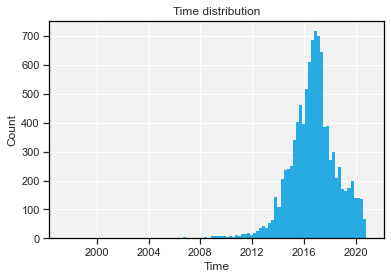

In [13]:
plt.hist(data['Date'], bins=100)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Time distribution')

plt.show()

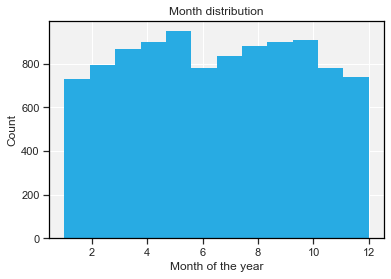

In [14]:
months = data['Date'].map(lambda t: t.month)

plt.hist(months, bins=12)
plt.xlabel('Month of the year')
plt.ylabel('Count')
plt.title('Month distribution')

plt.show()

The histogram of month distribution shows that larger number of games were released around May and October than on other months, which is predictable from the reality. There are two important world-wide gaming show annually: E3, GC, and TGS. Usually E3 starts around May and June, while GC and TGS are held around September and October. In order to attract people's attention on the show, many game developers choose to release many of their games around these two periods. At other times, the developers begin to design new games and prepare for the next show, only those unfamous Indie game developers not caring about the show release new games. This perfectly explains why the number of released games decreases significantly after May and October.  

Finally, we had the distribution of week days on which games were released: 

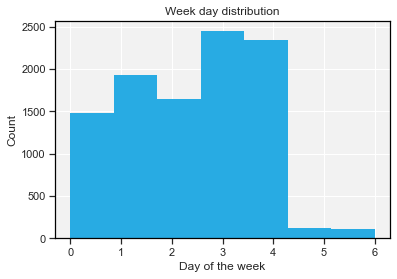

In [15]:
# 0: Monday, 6: Sunday
week_days = data['Date'].map(lambda t: t.weekday())

plt.hist(week_days, bins=7)
plt.xlabel('Day of the week')
plt.ylabel('Count')
plt.title('Week day distribution')

plt.show()

From the distribution, most games were released on Thursday and Friday, while very few games were released on weekends. Thursday and Friday are perfect for releasing games because they are close to the weekend, and it is easier for game fanatics to notice, purchase, and play games. So it is understandable that game developers choose to compete on these two days. The reason why few games were released on weekends is also obvious: at the precious rest time, gamers prefer playing their purchased games to wasting time on finding new games. Therefore, fewer people will notice games released on the weekend, making the game less profitable. 

### Genre

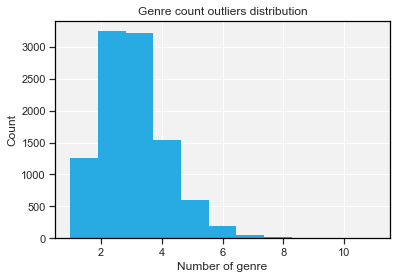

In [16]:
plt.hist(data["Genre Count"],bins=11)
plt.xlabel('Number of genre')
plt.ylabel('Count')
plt.title('Genre count outliers distribution')
plt.show()

In [17]:
## Genre count and percentage
append_genre = pd.Series(dtype=str)
for i in Genre_Columns:
    append_genre = append_genre.append(data[i])
Unique_genre = append_genre.unique()
Genre_stat = pd.DataFrame(append_genre.value_counts(),columns=["Count"])
Genre_stat["%"] = round(Genre_stat["Count"]/sum(Genre_stat["Count"])*100,2)

## Recommendation sum of each genre
df1 = data[["Genre1","Recommendations"]].groupby(by="Genre1").sum().reset_index().rename(columns= {"Genre1":"Genre","Recommendations":"R1"}) 
df2 = data[["Genre2","Recommendations"]].groupby(by="Genre2").sum().reset_index().rename(columns= {"Genre2":"Genre","Recommendations":"R2"})
df3 = data[["Genre3","Recommendations"]].groupby(by="Genre3").sum().reset_index().rename(columns= {"Genre3":"Genre","Recommendations":"R3"})
df4 = data[["Genre4","Recommendations"]].groupby(by="Genre4").sum().reset_index().rename(columns= {"Genre4":"Genre","Recommendations":"R4"})
df5 = data[["Genre5","Recommendations"]].groupby(by="Genre5").sum().reset_index().rename(columns= {"Genre5":"Genre","Recommendations":"R5"})
df6 = data[["Genre6","Recommendations"]].groupby(by="Genre6").sum().reset_index().rename(columns= {"Genre6":"Genre","Recommendations":"R6"})
df7 = data[["Genre7","Recommendations"]].groupby(by="Genre7").sum().reset_index().rename(columns= {"Genre7":"Genre","Recommendations":"R7"})
df8 = data[["Genre8","Recommendations"]].groupby(by="Genre8").sum().reset_index().rename(columns= {"Genre8":"Genre","Recommendations":"R8"})
df9 = data[["Genre9","Recommendations"]].groupby(by="Genre9").sum().reset_index().rename(columns= {"Genre9":"Genre","Recommendations":"R9"})
df10 = data[["Genre10","Recommendations"]].groupby(by="Genre10").sum().reset_index().rename(columns= {"Genre10":"Genre","Recommendations":"R10"})
df11 = data[["Genre11","Recommendations"]].groupby(by="Genre11").sum().reset_index().rename(columns= {"Genre11":"Genre","Recommendations":"R11"})

recom_by_genre = reduce(lambda  left,right: pd.merge(left,right,on=['Genre'],how='outer'), [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11])
recom_by_genre = recom_by_genre.fillna(0)
recom_by_genre["Total recommendations"] = recom_by_genre["R1"]+recom_by_genre["R2"]+recom_by_genre["R3"]+recom_by_genre["R4"]+recom_by_genre["R5"]+recom_by_genre["R6"]+recom_by_genre["R7"]+recom_by_genre["R8"]+recom_by_genre["R9"]+recom_by_genre["R10"]+recom_by_genre["R11"]
total_recom_by_genre = recom_by_genre[["Genre","Total recommendations"]]
total_recom_by_genre = total_recom_by_genre.sort_values(by="Total recommendations", ascending=False).reset_index().drop("index",axis=1)
total_recom_by_genre = total_recom_by_genre.set_index("Genre")
Genre_stat = Genre_stat.join(total_recom_by_genre)
Genre_stat["Recommendation %"] = round(Genre_stat["Total recommendations"]/sum(Genre_stat["Total recommendations"])*100,2)
# Average recommendation for each genre
Genre_stat["Average Recommendation"] = (Genre_stat["Total recommendations"]/Genre_stat["Count"])
Genre_stat["Average Recommendation %"] = round(Genre_stat["Average Recommendation"]/sum(Genre_stat["Average Recommendation"])*100,2)


Genre_stat.sort_values(by="Average Recommendation",ascending=False)

,Count,%,Total recommendations,Recommendation %,Average Recommendation,Average Recommendation %
Photo Editing,7,0.02,"207,593.00",0.32,"29,656.14",25.86
Animation & Modeling,11,0.04,"213,389.00",0.33,"19,399.00",16.91
Utilities,19,0.07,"219,355.00",0.34,"11,545.00",10.07
Design & Illustration,20,0.07,"224,359.00",0.35,"11,217.95",9.78
Massively Multiplayer,341,1.21,"2,836,026.00",4.39,"8,316.79",7.25
Free to Play,475,1.68,"3,666,340.00",5.67,"7,718.61",6.73
Action,4791,16.95,"17,611,594.00",27.24,"3,675.97",3.21
RPG,2055,7.27,"6,463,734.00",10.00,"3,145.37",2.74
Simulation,1710,6.05,"4,741,217.00",7.33,"2,772.64",2.42
Adventure,4274,15.12,"9,548,637.00",14.77,"2,234.12",1.95


In [18]:
labels = list(Genre_stat.index)
count = list(Genre_stat.Count)
total_r = list(Genre_stat["Total recommendations"])
avg_r = list(Genre_stat["Average Recommendation"])

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=count, name="Genre Count"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=total_r, name="Total recommendations"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=avg_r, name="Average Recommendation"),
              1, 3)
                        
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.5, textposition='inside', hoverinfo="label+percent+value",textinfo='value')

fig.update_layout(
    title_text="Count and Recommendation by Genre of Games",
    uniformtext_minsize=12, uniformtext_mode='hide',
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Count', x=0.11, y=0.5, font_size=14, showarrow=False),
                 dict(text='Recommend', x=0.5, y=0.5, font_size=14, showarrow=False),
                 dict(text='Average', x=0.9, y=0.53, font_size=14, showarrow=False),
                 dict(text='Recommend', x=0.92, y=0.48, font_size=14, showarrow=False)])
fig.show()

### Developer

As we would probably expect, the mean is 1.13 with a standard deviation of 0.43.


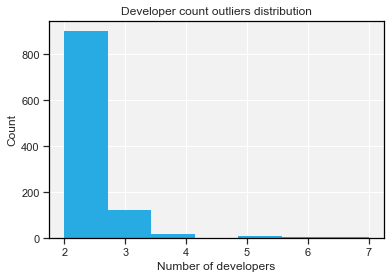

In [19]:
print('As we would probably expect, the mean is {:0.2f} with a standard deviation of {:0.2f}.'\
      .format(data["Developer Count"].mean(),data["Developer Count"].std()))

plt.hist(data[data["Developer Count"] > 1]["Developer Count"],bins=7)
plt.xlabel('Number of developers')
plt.ylabel('Count')
plt.title('Developer count outliers distribution')
plt.show()

$\color{orange}{同上有空还想弄一个根据developer加总recommendation总数的chart，没想好怎么弄，弄不出就算了}$

In [20]:
## Developer Statistics
append_developer = data["Developer Major"].append(data["Developer 2"])
Unique_developer = append_developer.unique()
Developer_stat = pd.DataFrame(append_developer.value_counts(),columns=["Count"])
Developer_stat.head(40)
# Developer_stat = Developer_stat.drop(labels=["Inc.","LLC","Ltd.","LTD.","Feral Interactive (Linux)"])
# Developer_stat["%"] = round(Developer_stat["Count"]/sum(Developer_stat["Count"])*100,2)
# Developer_stat.head(20)

,Count
Inc.,75
LLC,66
Ltd.,52
Square Enix,33
EnsenaSoft,32
LTD.,31
Warfare Studios,29
Alawar Entertainment,29
Winged Cloud,27
Idea Factory,23


### Price

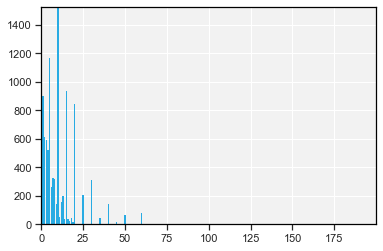

,Price,Count
0,9.99,1526
1,4.99,1166
2,14.99,935
3,0.99,897
4,19.99,844
...,...,...
57,1.20,1
58,2.79,1
59,28.99,1
60,45.00,1


In [21]:
## Price Distribution
Price_stat = pd.DataFrame(data["Final price"].astype(float).value_counts()).reset_index().rename(columns={"index":"Price","Final price":"Count"})

plt.xlim(0, Price_stat.Price.max())
plt.ylim(0, Price_stat.Count.max())
plt.bar("Price", "Count", data=Price_stat)
plt.show()

Price_stat

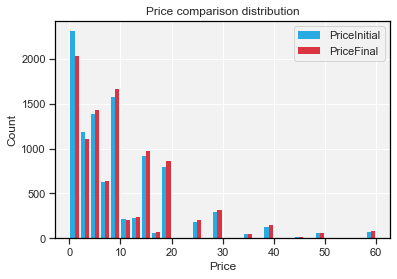

In [22]:
plt.hist([data["Initial price"], data["Final price"]], bins=30, range=(0,60), label=['PriceInitial', 'PriceFinal'])
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price comparison distribution')
plt.show()

### Recommendation

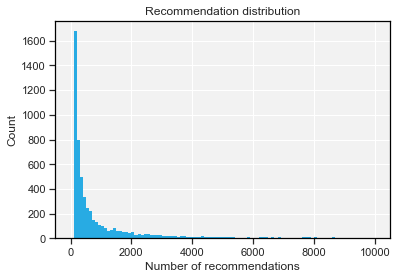

In [23]:
plt.hist(data[data["Recommendations"]>0]["Recommendations"],bins=100,range=(1,10000))
plt.xlabel('Number of recommendations')
plt.ylabel('Count')
plt.title('Recommendation distribution')
plt.show()

In [24]:
## Most Recommended
Recommend_stat = data[["Appid","Game name","Recommendations", "Date", "Final price","Genre"]].sort_values(by=["Recommendations"],ascending=False)
Recommend_stat.head(20)

KeyError: "['Genre'] not in index"

In [ ]:
## Characteristic of the recommended (100)
Recommend = data.sort_values(by=["Recommendations"],ascending=False).head(100).drop(columns=["Category","Genre","Developer"])

## Data Description of recommended games(top 100)
pd.options.display.float_format = '{:,.2f}'.format
Recommend[["Recommendations","Initial price","Final price","Developer Count","Genre Count"]].describe()

,Recommendations,Initial price,Final price,Developer Count,Genre Count
count,100.00,100.00,100.00,100.00,100.00
mean,"150,839.08",25.64,26.64,1.49,2.32
std,"314,897.10",16.21,15.44,1.13,1.22
min,"41,423.00",0.00,0.00,1.00,1.00
25%,"50,127.50",14.99,14.99,1.00,1.00
50%,"69,075.00",19.99,19.99,1.00,2.00
75%,"128,463.75",29.99,29.99,1.00,3.00
max,"2,850,475.00",59.99,59.99,7.00,7.00


Compared to the whole dataset, the top 100 most recommended games have an overall higher price($26 vs $10), more developers(1.5 vs 1.1) and more focued genres(2.3 vs 2.9). Also, people are more likely to prefer games with Multi-player, Co-op and PvP modes compared to those merely single-player games. The features of remote play on phone is also preferred.

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format
Recommend[Category_Columns].describe()

,Single-player,Multi-player,Co-op,MMO,VR Support,PvP,Remote Play on Phone
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,0.86,0.61,0.42,0.04,0.01,0.28,0.39
std,0.35,0.49,0.50,0.20,0.10,0.45,0.49
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,1.00,1.00,0.00,0.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
append_genre_R = pd.Series(dtype=str)
for i in Genre_Columns:
    append_genre_R = append_genre_R.append(Recommend[i])
Unique_genre_R = append_genre_R.unique()
Genre_stat_R = pd.DataFrame(append_genre_R.value_counts(),columns=["Count"])
Genre_stat_R["%"] = round(Genre_stat_R["Count"]/sum(Genre_stat_R["Count"])*100,2)
Genre_stat_R.head(10)

,Count,%
Action,65,28.02
Indie,42,18.10
Adventure,39,16.81
RPG,26,11.21
Simulation,21,9.05
Strategy,19,8.19
Massively Multiplayer,6,2.59
Casual,5,2.16
Free to Play,2,0.86
Racing,1,0.43


In [ ]:
Unique_genre = list(Unique_genre)
Unique_genre = list(filter(bool, Unique_genre))
numerical_columns = ["Recommendations","Genre Count","Developer Count"] + Unique_genre + Category_Columns
cm = sns.light_palette("green", as_cmap=True)
corr = data[numerical_columns].corr()
corr.style.background_gradient(cmap=cm)